In [1]:
#importing packages to compile Torch and utilities

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# ls
# listing stuff in memory

In [3]:
#defining local batch size and train and test datasets

locBatchSize = 64
# locBatchSize = 4096

transform = transforms.Compose([
    transforms.Resize(224),  # AlexNet was trained with 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize the data.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=locBatchSize, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=locBatchSize, shuffle=False, num_workers=2)

# order is important !
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

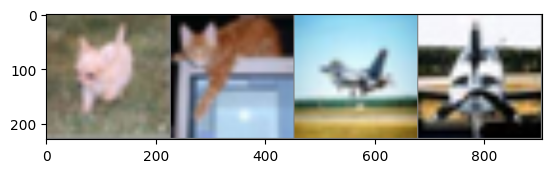

 dog || cat || plane || plane


In [10]:
def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

#pulling a sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))

In [11]:
images[1].shape #checking images are the same sizes which AlexNet was trined

#the zero entry of this vector also defines the entry of the first convolutional layer

torch.Size([3, 224, 224])

In [12]:
#Load Pretrained AlexNet
model = torchvision.models.alexnet(pretrained=True) ## AlexNet pretrained using ImageNet

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10) # 10 output classes

# model = model().to(device)

/Users/carolinabernal/Documents/DiplomadoExercises/tensorflow_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/carolinabernal/Documents/DiplomadoExercises/tensorflow_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
count_params( model )

57044810

In [15]:
# 4. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
num_epochs = 20
history_new = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}

for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()

    running_loss = 0.0
    correct = 0
    total= 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # Ensure labels are long type
        labels = labels.long()

        loss = criterion(outputs, labels) # Corrected order: outputs, labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 *  correct / total
    train_loss = running_loss / len(trainloader)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradients during validation
        for i, data in enumerate(testloader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) # get the prediction

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct_val += (predicted == labels).sum().item() # count correct predictions
            total_val += labels.size(0)

    val_acc = 100 *  correct_val / total_val
    val_loss /= len(testloader)

    history_new["val_loss"].append(val_loss)
    history_new["val_acc"].append(val_acc)
    history_new["loss"].append(train_loss)
    history_new["acc"].append(train_acc)

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

print('Finished Training')

Epoch [1/20], Loss: 0.5273, Accuracy: 76.87%
Epoch [2/20], Loss: 0.4921, Accuracy: 85.77%
Epoch [3/20], Loss: 0.3419, Accuracy: 88.19%
Epoch [4/20], Loss: 0.3888, Accuracy: 90.00%
Epoch [5/20], Loss: 0.3700, Accuracy: 91.51%
Epoch [6/20], Loss: 0.2598, Accuracy: 92.50%
Epoch [7/20], Loss: 0.3584, Accuracy: 93.72%
Epoch [8/20], Loss: 0.6400, Accuracy: 93.95%
Epoch [9/20], Loss: 0.2776, Accuracy: 95.05%
Epoch [10/20], Loss: 0.2941, Accuracy: 95.56%
Epoch [11/20], Loss: 0.2872, Accuracy: 96.16%
Epoch [12/20], Loss: 0.3994, Accuracy: 96.60%
Epoch [13/20], Loss: 0.2495, Accuracy: 96.86%
Epoch [14/20], Loss: 0.3120, Accuracy: 97.19%
Epoch [15/20], Loss: 0.2199, Accuracy: 97.72%
Epoch [16/20], Loss: 0.2368, Accuracy: 97.90%
Epoch [17/20], Loss: 0.3661, Accuracy: 98.10%
Epoch [18/20], Loss: 0.3985, Accuracy: 98.21%
Epoch [19/20], Loss: 0.1686, Accuracy: 98.43%
Epoch [20/20], Loss: 0.2017, Accuracy: 98.59%
Finished Training


/var/folders/hr/yrdz47796ml5sfbpmg4kmttr0000gn/T/ipykernel_51503/4138539773.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
/var/folders/hr/yrdz47796ml5sfbpmg4kmttr0000gn/T/ipykernel_51503/4138539773.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')


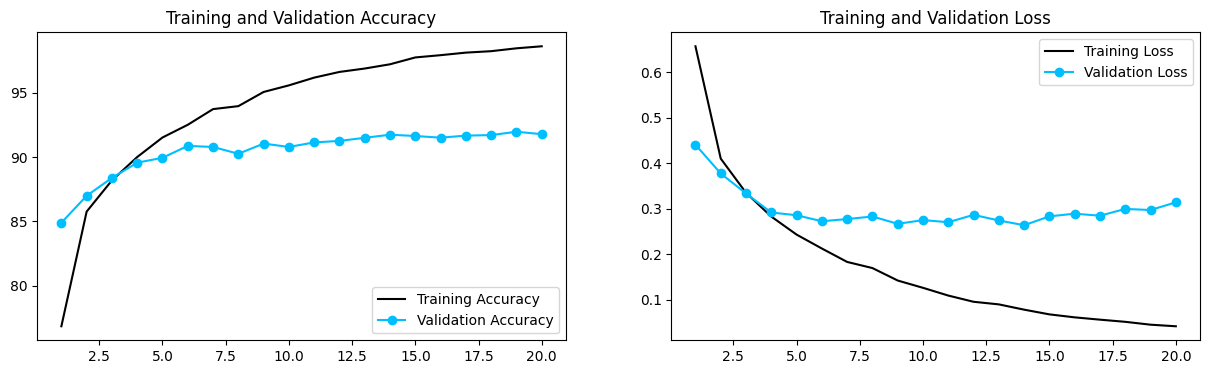

In [18]:
# Plot Training History (Optional but very useful)
acc = history_new['acc']
val_acc = history_new['val_acc']

loss = history_new['loss']
val_loss = history_new['val_loss']

epochs_range = range(1, 20+1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
plt.plot(epochs_range, val_acc, '-o' ,label='Validation Accuracy', color = 'deepskyblue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')
plt.plot(epochs_range, val_loss, '-o' ,label='Validation Loss', color = 'deepskyblue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('pre_trained_modelPyTorch_AlexNet.jpg')

plt.show()

In [19]:
# 7. Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 91.77 %


In [20]:
# 8. Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 96.43 %
Accuracy of car   : 100.00 %
Accuracy of bird  : 91.14 %
Accuracy of cat   : 76.71 %
Accuracy of deer  : 96.36 %
Accuracy of dog   : 88.14 %
Accuracy of frog  : 94.64 %
Accuracy of horse : 89.06 %
Accuracy of ship  : 100.00 %
Accuracy of truck : 93.59 %


In [21]:
state_dict = model.state_dict()  # Get the model weights